In [53]:
import numpy as np;
import scipy as sp;
import matplotlib.pyplot as plt;
import math;
from pdb import set_trace

# Part 1 Implementation of the algorithm

In [59]:
# Componentwise shrinkage thresholding
def CST(X, tau):
#    return np.maximum(np.abs(X) - tau, 0) * np.sign(X)
    return np.maximum(np.abs(X) - tau, 0) * np.sign(X)

# Singular values thresholding
def SVT(X, tau):
    (u, s, v) = np.linalg.svd(X, full_matrices=False)
    d = np.diag(CST(s, tau))
    return np.dot(u, np.dot(d, v))
    
# Low Rank Matrix Completion
def lrmc(X, W, tau = 1000, beta = 2, max_iters = 100, A_init=None):
    A = np.empty_like(X)
    Z = np.zeros_like(X) if A_init is None else beta * (X - A_init) * W
    for i in range(max_iters):
        A = SVT(Z * W, tau)
        S = beta * (X - A) * W
        Z += S
        if np.max(np.abs(S)) < 0.1:
            break
            
    return A

In [60]:
def corrupt(im, ratio):
    W = np.random.binomial(1, 1 - ratio, im.shape)
    A = im * W
    return (A, W)

def MSE(im1, im2, W):
    diffim = (im2 - im1) * (1 - W)
    return np.sum(diffim * diffim) / np.sum(1 - W)

In [61]:
def PCA(X, d):
    u, s, v = np.linalg.svd(X, full_matrices=False)
    #print("highest sv removed :", s[d])
    s[d:] = 0
    Y = np.dot(u, np.dot(np.diag(s), v))
    return Y

# Part 2 Face completion

## Images as vector

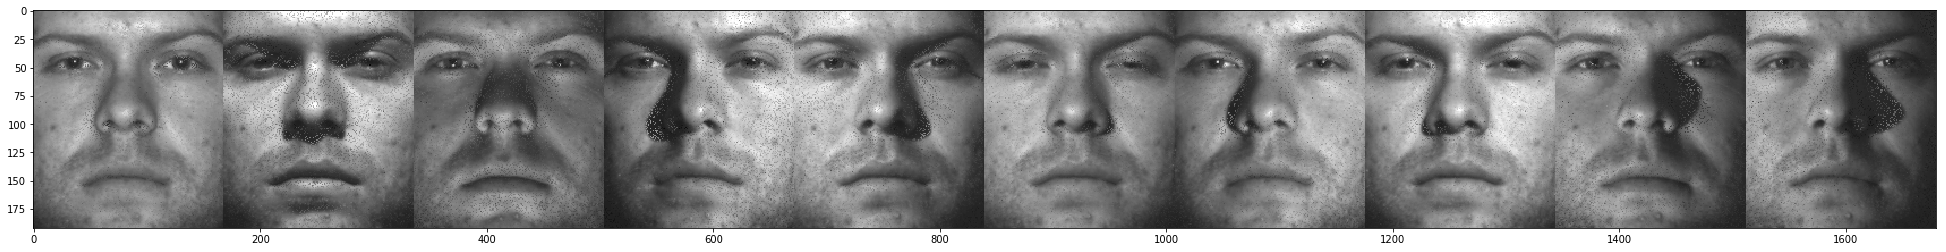

MSE : 383.127939815


In [62]:
from PIL import Image

images_dir = "../data/images/"
images_list = "list.info"
(imW, imH) = (192, 168)

files = np.genfromtxt(images_dir + images_list, dtype='str')

images = np.empty((imW, imH, len(files)))
for i, file in enumerate(files):
    images[:,:, i] = np.array(Image.open(images_dir + file))
    
imvect = images.reshape((imW*imH, len(files)))

X, W = corrupt(imvect, 0.20)

A = lrmc(X, W, tau=100000, beta=2, max_iters=1000)

output = A.reshape((imW, imH, len(files)))
output = output.reshape((imW, imH * len(files)), order='F')

plt.figure(figsize=(40, 4))
plt.imshow(output, cmap='gray')
plt.show()

print("MSE :", MSE(A, imvect, W))

## All figures

In [67]:
from PIL import Image

images_dir = "../data/images/"
images_list = "list_prof.info"
(imW, imH) = (96, 84)

files = np.genfromtxt(images_dir + images_list, dtype='str')

images = np.empty((imW, imH, len(files)))
for i, file in enumerate(files):
    images[:,:, i] = np.array(Image.open(images_dir + file))
    
imvect = images.reshape((imW*imH, len(files)))

select_im = 1

taus = [1e3, 2e4, 4e5, 8e6]
#rhos = [0.1, 0.2, 0.4, 0.6, 0.8]
rhos = [0.3, 0.5, 0.7, 0.8, 0.9]

im_recov = np.empty((imW, imH, len(rhos), len(taus)))
im_orig = np.empty((imW, imH, len(rhos)))
MSEs = np.empty((len(rhos), len(taus)))

for ir, rho in enumerate(rhos):
    
    X, W = corrupt(imvect, rho)
    im_orig[:, :, ir] = X[:, select_im].reshape((imW, imH))
    
    for it, tau in enumerate(taus):
        
        beta = min(2.0, 1.0 / (1 - rho))
        A = lrmc(X, W, tau, beta=2, max_iters=1000)
        
        im_recov[:, :, ir, it] = A[:, select_im].reshape((imW, imH))
        MSEs[ir, it] = MSE(A, imvect, W)
        
        print("%d/%d" % (ir * len(taus) + it + 1, len(rhos) * len(taus)))


1/20
2/20
3/20
4/20
5/20
6/20
7/20
8/20
9/20
10/20
11/20
12/20
13/20
14/20
15/20
16/20
17/20
18/20
19/20
20/20


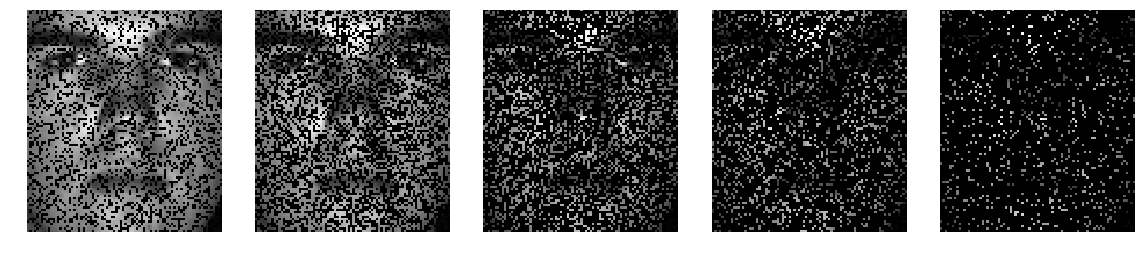

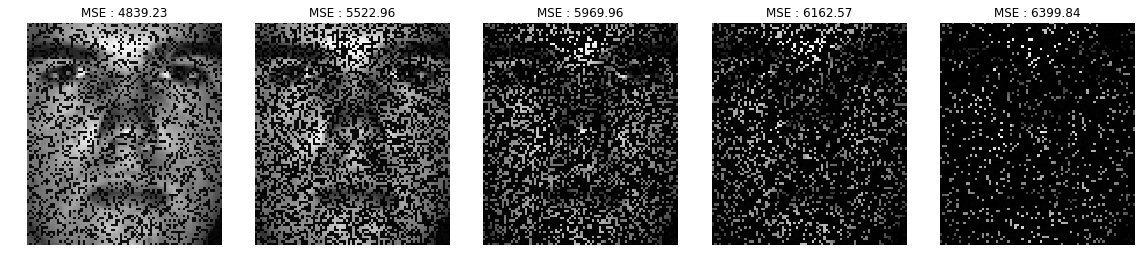

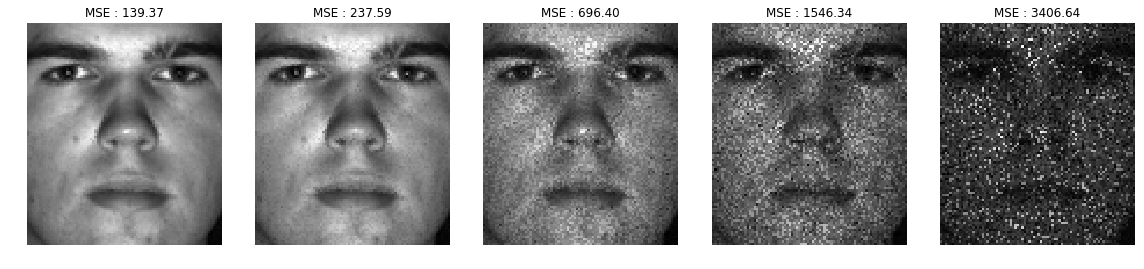

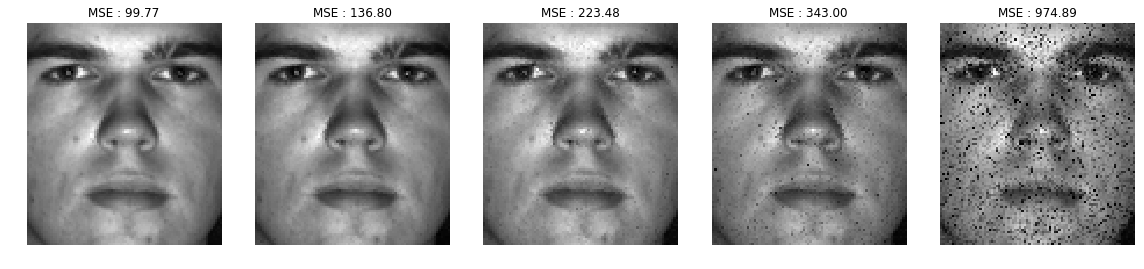

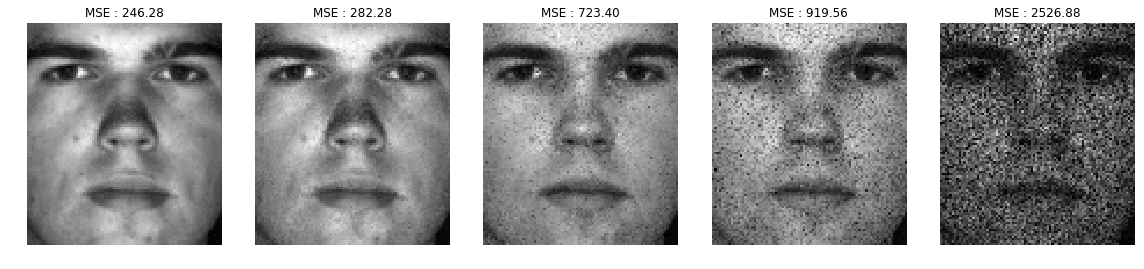

In [68]:
def display_original_image_lines(ims, rhos):
    
    f, axarr = plt.subplots(1, len(rhos), figsize=(16, len(rhos) * 16))
    for ir, rho in enumerate(rhos):
        axarr[ir].imshow(ims[:, :, ir], cmap='gray')
        axarr[ir].axis('off')
    plt.tight_layout()
    plt.show()

def display_images_lines(ims, mses, rhos, taus):
    
    for it, tau in enumerate(taus):
        f, axarr = plt.subplots(1, len(rhos), figsize=(16, len(rhos) * 16))
        for ir, rho in enumerate(rhos):
            axarr[ir].imshow(ims[:, :, ir, it], cmap='gray')
            axarr[ir].axis('off')
            axarr[ir].set_title("MSE : %.2f" % mses[ir, it])
        plt.tight_layout()
        plt.savefig("one_face_%d.png" % tau)
        plt.show()

def display_images(ims, mses, rhos, taus):
    f, axarr = plt.subplots(len(taus), len(rhos), figsize=(len(rhos) * 4, len(taus) * 4))
    
    for it, tau in enumerate(taus):
        for ir, rho in enumerate(rhos):
            axarr[it, ir].imshow(ims[:, :, ir, it], cmap='gray')
            axarr[it, ir].axis('off')
            axarr[it, ir].set_title("MSE : %.2f" % mses[ir, it])
            

    plt.show()
    
display_original_image_lines(im_orig, rhos)

display_images_lines(im_recov, MSEs, rhos, taus)

# Part 3 Movie recommandation grand challenge

(231, 787)
(231, 828)
(231, 1615)
Tau = 100
Computing romance MSE with cross validation
iterations :  48
1/10 : MSE = 5.30
iterations :  46
2/10 : MSE = 5.55
iterations :  51
3/10 : MSE = 5.39
iterations :  50
4/10 : MSE = 5.43
iterations :  50
5/10 : MSE = 5.48
iterations :  65
6/10 : MSE = 5.22
iterations :  48
7/10 : MSE = 5.35
iterations :  50
8/10 : MSE = 5.21
iterations :  363
9/10 : MSE = 4.95
iterations :  50
10/10 : MSE = 5.43
Computing horror MSE with cross validation
iterations :  72
1/10 : MSE = 5.54
iterations :  75
2/10 : MSE = 5.47
iterations :  73
3/10 : MSE = 5.29
iterations :  85
4/10 : MSE = 5.31
iterations :  70
5/10 : MSE = 5.05
iterations :  70
6/10 : MSE = 5.25
iterations :  73
7/10 : MSE = 5.02
iterations :  71
8/10 : MSE = 5.25
iterations :  75
9/10 : MSE = 5.29
iterations :  69
10/10 : MSE = 5.36
Computing horror and romance MSE with cross validation
iterations :  80
1/10 : MSE = 5.54
iterations :  79
2/10 : MSE = 5.59
iterations :  73
3/10 : MSE = 5.48
iterat

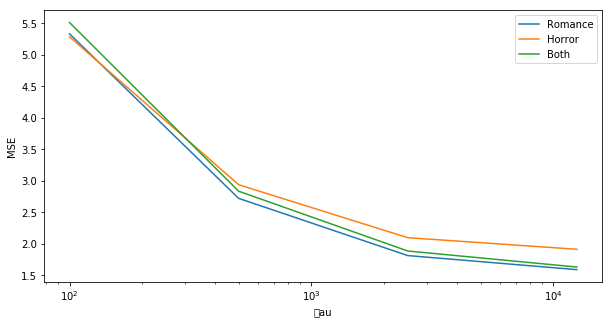

In [47]:
import numpy as np

# Insane code incoming
def reindex(X):
    ids = np.argsort(X)
    D = np.ma.ediff1d(X[ids], to_begin=[0])
    D[D != 0] = 1
    R = np.empty_like(X)
    R[ids] = np.cumsum(D)
    return R
    
def compute_matrix(data):
    users = reindex(data[:, 0].astype(int))
    movies = reindex(data[:, 2].astype(int))
    #movies = data[:, 5].astype(int)
    #users = data[:, 6].astype(int)
    ratings = data[:, 3].astype(float)
    matrix = np.zeros((np.max(users) + 1, np.max(movies) + 1))
    matrix[users, movies] = ratings
    return matrix

def compute_mse_cross(X, W, tau=10000, beta=2, max_iters=300, cross=0.1):
    ids = np.array(np.nonzero(W))
    shuffle = np.random.permutation(np.arange(ids.shape[1]))
    ids = ids[:, shuffle]
    ids_array = np.array_split(ids, 1/cross, axis=1)
    
    sum_mse = 0
    for i, ids in enumerate(ids_array):
        W_train = W.copy()
        W_train[ids[0], ids[1]] = 0
        W_test = W - W_train
        A = lrmc(X, W_train, tau, beta, max_iters)
        mse = MSE(A, X, 1 - W_test)
        sum_mse += mse;
        print("%d/%d : MSE = %.2f" % (i + 1, len(ids_array), mse))
    
    return sum_mse / len(ids_array)


dataset = np.genfromtxt("../data/movielens/movielens.csv", delimiter=',', dtype='str')
header = dataset[1,:]
data = dataset[1:, :]

horror_ids = (data[:, 1] == '1')
romance_ids = (data[:, 1] == '2')


horror_data = data[horror_ids]
romance_data = data[romance_ids]

X_romance = compute_matrix(romance_data)
X_horror = compute_matrix(horror_data)
X_all = compute_matrix(data)

print(X_romance.shape)
print(X_horror.shape)
print(X_all.shape)

train_percent = 0.9

W_romance = np.where(X_romance != 0, 1, 0)
W_horror = np.where(X_horror != 0, 1, 0)
W_all = np.where(X_all != 0, 1, 0)

mse_romance = []
mse_horror = []
mse_all = []
tau_array = [100, 500, 2500, 12500]
for tau in tau_array:
    
    print("Tau =", tau)
    
    print("Computing romance MSE with cross validation")
    mse_romance.append(compute_mse_cross(X_romance, W_romance, tau=tau, beta=2, max_iters=1000, cross=0.1))
    print("Computing horror MSE with cross validation")
    mse_horror.append(compute_mse_cross(X_horror, W_horror, tau=tau, beta=2, max_iters=1000, cross=0.1))
    print("Computing horror and romance MSE with cross validation")
    mse_all.append(compute_mse_cross(X_all, W_all, tau=tau, beta=2, max_iters=1000, cross=0.1))

plt.figure(figsize=(10,5))
plt.semilogx(tau_array, mse_romance, label='Romance')
plt.semilogx(tau_array, mse_horror, label='Horror')
plt.semilogx(tau_array, mse_all, label='Both')
plt.xlabel("\tau")
plt.ylabel("MSE")
plt.legend()
plt.show()


In [51]:
print(mse_romance)
print(mse_horror)
print(mse_all)

[5.3314752887223964, 2.7190947444984537, 1.8107201064292848, 1.5872350079589956]
[5.2841798343795725, 2.9357980655330005, 2.0948663871654576, 1.9108511676608679]
[5.5108866718293221, 2.8331383848845686, 1.8832640536550893, 1.6287501263609259]


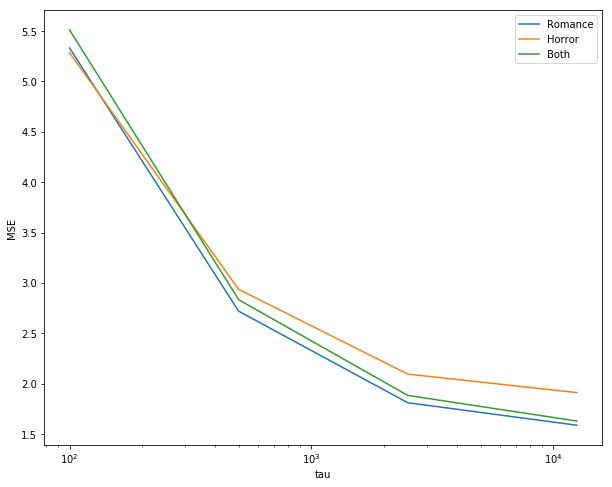

In [50]:
plt.figure(figsize=(10,8))
plt.semilogx(tau_array, mse_romance, label='Romance')
plt.semilogx(tau_array, mse_horror, label='Horror')
plt.semilogx(tau_array, mse_all, label='Both')
plt.xlabel("tau")
plt.ylabel("MSE")
plt.legend()
plt.show()